In [1]:
import math
import torch
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt
import numpy as np

from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector

from mmcv.parallel import collate, scatter
from mmcv.ops import RoIPool
from mmcv import Config, DictAction
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmdet.core.utils import filter_scores_and_topk, select_single_mlvl
from mmdet.core import (bbox2roi, multiclass_nms)

## 1. Init Your config and model

In [21]:
# config = '../configs/Outliers/aster_rcnn_r50_fpn_1x_trash.py'
config = './configs/Outliers/faster_rcnn_r50_fpn_1x_trash.py'
cfg = Config.fromfile(config)

# wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_c4_1x_coco/faster_rcnn_r50_caffe_c4_1x_coco_20220316_150152-3f885b85.pth
checkpoint_path = './work_dirs/train_fold_5/latest.pth'
device = 'cuda:0'
model = init_detector(config)
checkpoint = load_checkpoint(model, checkpoint_path, map_location=device)

checkpoint['meta']['CLASSES']=('General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 
           'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing')
print(checkpoint['meta'].keys())
# checkpoint.mets
label_names = checkpoint['meta']['CLASSES']
model.CLASSES = checkpoint['meta']['CLASSES']

load checkpoint from local path: ./work_dirs/train_fold_5/latest.pth
dict_keys(['epoch', 'iter', 'mmcv_version', 'time', 'CLASSES'])


## Visualize an image

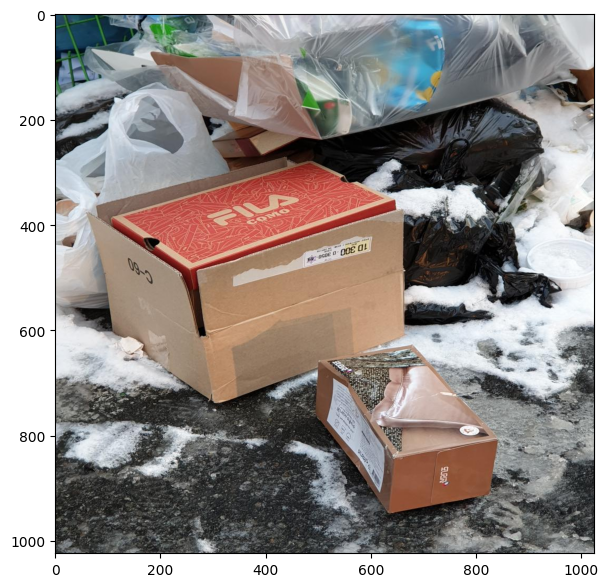

In [23]:
image_path = "../../dataset/train/0005.jpg"
image = cv2.imread(image_path)
# scale = 600 / min(image.shape[:2])
# image = cv2.resize(image,
#                    dsize = (448, 448),
#                    interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

## Predict the results with Faster R-CNN C4

1 Paper (131, 52, 803, 1003) 0.9832857
1 Paper (832, 737, 1024, 1013) 0.92472637
1 Paper (70, 511, 803, 1007) 0.89317524
1 Paper (596, 822, 758, 1021) 0.8465903
1 Paper (0, 680, 60, 1024) 0.80904156
1 Paper (42, 747, 758, 1019) 0.7992512
1 Paper (899, 675, 1024, 776) 0.6226898
1 Paper (4, 113, 138, 272) 0.61245507
1 Paper (799, 635, 883, 960) 0.6083873
1 Paper (2, 491, 118, 750) 0.5687418
7 Plastic bag (948, 596, 1019, 709) 0.45516032


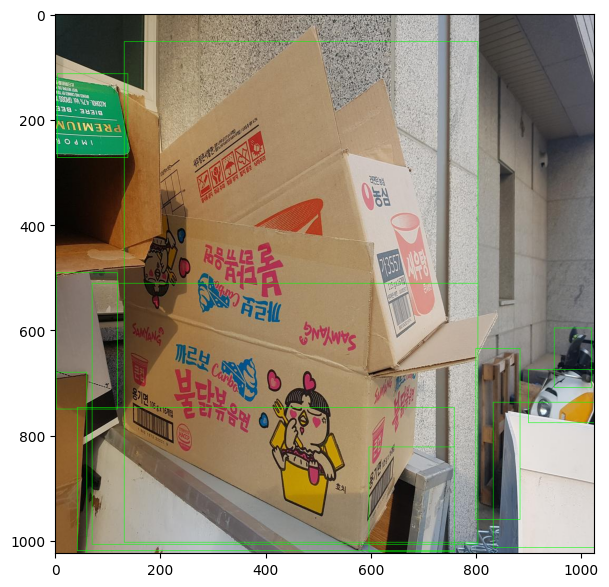

In [266]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.4:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 1)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

## 2. This is the core demo for Grad CAM

In [267]:
# GPU version
class GradCAM_FRCN(object):
    """
    Grad CAM for Faster R-CNN C4 in mmdetection framework, this is not the latest, please refer to interpretation/gradcam.py
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        # print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()
    
    def rpn_get_bboxes(self, cls_scores,
                   bbox_preds,
                   score_factors=None,
                   img_metas=None,
                   cfg=None,
                   rescale=False,
                   with_nms=False,
                   **kwargs):
        assert len(cls_scores) == len(bbox_preds)
        if score_factors is None:
            # e.g. Retina, FreeAnchor, Foveabox, etc.
            with_score_factors = False
        else:
            # e.g. FCOS, PAA, ATSS, AutoAssign, etc.
            with_score_factors = True
            assert len(cls_scores) == len(score_factors)

        num_levels = len(cls_scores)

        featmap_sizes = [cls_scores[i].shape[-2:] for i in range(num_levels)]
        mlvl_priors = self.net.rpn_head.prior_generator.grid_priors(
            featmap_sizes,
            dtype=cls_scores[0].dtype,
            device=cls_scores[0].device)

        result_list = []

        for img_id in range(len(img_metas)):
            img_meta = img_metas[img_id]
            cls_score_list = select_single_mlvl(cls_scores, img_id, detach=False)
            bbox_pred_list = select_single_mlvl(bbox_preds, img_id, detach=False)
            if with_score_factors:
                score_factor_list = select_single_mlvl(score_factors, img_id, detach=False)
            else:
                score_factor_list = [None for _ in range(num_levels)]

            results = self.net.rpn_head._get_bboxes_single(cls_score_list, bbox_pred_list,
                                              score_factor_list, mlvl_priors,
                                              img_meta, cfg, rescale, with_nms,
                                              **kwargs)
            result_list.append(results)
        return result_list
    
    def simple_test_bboxes(self,
                           x,
                           img_metas,
                           proposals,
                           rcnn_test_cfg,
                           rescale=False):
        """Test only det bboxes without augmentation.
        This function needn't read.
        """
        rois = bbox2roi(proposals)
        # print("rois: {}".format(rois.shape))
        if rois.shape[0] == 0:
            batch_size = len(proposals)
            det_bbox = rois.new_zeros(0, 5)
            det_label = rois.new_zeros((0, ), dtype=torch.long)
            if rcnn_test_cfg is None:
                det_bbox = det_bbox[:, :4]
                det_label = rois.new_zeros(
                    (0, self.net.roi_head.bbox_head.fc_cls.out_features))
            # There is no proposal in the whole batch
            return [det_bbox] * batch_size, [det_label] * batch_size

        bbox_results = self.net.roi_head._bbox_forward(x, rois)
        img_shapes = tuple(meta['img_shape'] for meta in img_metas)
        scale_factors = tuple(meta['scale_factor'] for meta in img_metas)

        # split batch bbox prediction back to each image
        cls_score = bbox_results['cls_score']
        bbox_pred = bbox_results['bbox_pred']
        num_proposals_per_img = tuple(len(p) for p in proposals)
        rois = rois.split(num_proposals_per_img, 0)
        cls_score = cls_score.split(num_proposals_per_img, 0)

        # some detector with_reg is False, bbox_pred will be None
        if bbox_pred is not None:
            # TODO move this to a sabl_roi_head
            # the bbox prediction of some detectors like SABL is not Tensor
            if isinstance(bbox_pred, torch.Tensor):
                bbox_pred = bbox_pred.split(num_proposals_per_img, 0)
            else:
                bbox_pred = self.net.roi_head.bbox_head.bbox_pred_split(
                    bbox_pred, num_proposals_per_img)
        else:
            bbox_pred = (None, ) * len(proposals)

        # apply bbox post-processing to each image individually
        det_bboxes = []
        det_labels = []
        for i in range(len(proposals)):
            if rois[i].shape[0] == 0:
                # There is no proposal in the single image
                det_bbox = rois[i].new_zeros(0, 5)
                det_label = rois[i].new_zeros((0, ), dtype=torch.long)
                if rcnn_test_cfg is None:
                    det_bbox = det_bbox[:, :4]
                    det_label = rois[i].new_zeros(
                        (0, self.net.roi_head.bbox_head.fc_cls.out_features))

            else:
                det_bbox, det_label, det_inds = self.get_bboxes(
                    rois[i],
                    cls_score[i],
                    bbox_pred[i],
                    img_shapes[i],
                    scale_factors[i],
                    rescale=rescale,
                    cfg=rcnn_test_cfg)
            
            det_bboxes.append(det_bbox)
            det_labels.append(det_label)
        return det_bboxes, det_labels, det_inds
    
    def get_bboxes(self,
                   rois,
                   cls_score,
                   bbox_pred,
                   img_shape,
                   scale_factor,
                   rescale=False,
                   cfg=None):
        
        scores = F.softmax(
            cls_score, dim=-1) if cls_score is not None else None
        # bbox_pred would be None in some detector when with_reg is False,
        # e.g. Grid R-CNN.
        if bbox_pred is not None:
            bboxes = self.net.roi_head.bbox_head.bbox_coder.decode(
                rois[..., 1:], bbox_pred, max_shape=img_shape)
        else:
            bboxes = rois[:, 1:].clone()
            if img_shape is not None:
                bboxes[:, [0, 2]].clamp_(min=0, max=img_shape[1])
                bboxes[:, [1, 3]].clamp_(min=0, max=img_shape[0])

        if rescale and bboxes.size(0) > 0:
            scale_factor = bboxes.new_tensor(scale_factor)
            bboxes = (bboxes.view(bboxes.size(0), -1, 4) / scale_factor).view(
                bboxes.size()[0], -1)
        if cfg is None:
            return bboxes, scores
        else:
            det_bboxes, det_labels, inds = multiclass_nms(bboxes, scores,     # return_inds=True
                                                    cfg.score_thr, cfg.nms,
                                                    cfg.max_per_img, return_inds=True)
            return det_bboxes, det_labels, inds

    def __call__(self, data, index=0):
        """
        :param image: cv2 format, single image
        :param index: Which bounding box
        :return:
        """
        self.net.zero_grad()
        # Important
        feat = self.net.extract_feat(data['img'][0].cuda())

        if type(data['img_metas'][0]) == list:
            img_metas = data['img_metas'][0]
        else:
            img_metas = data['img_metas'][0].data[0]
        
        rpn_outs = self.net.rpn_head(feat)
        proposal_list = self.rpn_get_bboxes(*rpn_outs, img_metas=img_metas)
        # print(proposal_list[0].shape)
        # proposal_list = model.rpn_head.simple_test_rpn(feat, img_metas)
        # res = model.roi_head.simple_test(feat, proposal_list, img_metas, rescale=True)
        res = self.simple_test_bboxes(feat, img_metas, proposal_list, self.net.roi_head.test_cfg, rescale=True)
        ind = int(res[2][index]/len(self.net.CLASSES))
        score = res[0][0][index][4]
       
        score.backward()
        # print(res[0][0].shape)
        # # print(self.gradient)
        # print(self.feature.shape)
        
        gradient = self.gradient[ind]  # [C,H,W]
        weight = torch.mean(gradient, axis=(1, 2))  # [C]

        feature = self.feature[ind]  # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = torch.sum(cam, axis=0)  # [H,W]
        cam = torch.relu(cam)  # ReLU

        # Normalization
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        # resize to 224*224
        box = res[0][0][index][:-1].cpu().detach().numpy().astype(np.int32)
        
        class_id = res[1][0][index].cpu().detach().numpy()
        return cam.cpu().detach().numpy(), box, class_id, score.cpu().detach().numpy()


## If you just an image in opencv format, this is a preparation function

In [265]:
def prepare_img(imgs):
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    cfg = model.cfg
    device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)
    # print(datas)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        for m in model.modules():
            assert not isinstance(
                m, RoIPool
            ), 'CPU inference with RoIPool is not supported currently.'

    return data

## These functions are used for rendering images

In [268]:
def norm_image(image):
    """
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

def gen_cam(image, mask):
    """
    :param image: [H,W,C],
    :param mask: [H,W], 
    :return: tuple(cam,heatmap)
    """
    # mask to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb

    heatmap = cv2.resize(heatmap,
        dsize = (image.shape[1], image.shape[0]))

    # merge heatmap to original image
    # cam = heatmap + np.float32(image)
    return (heatmap * 255).astype(np.uint8)

def plot_cam_image(img, mask, box, class_id, score, bbox_index, COLORS, label_names):
    """
    Merge the CAM map to original image
    """
    height, width = img.shape[:2]

    image_tmp = img.copy()
    x1, y1, x2, y2 = box
    # predict_box = img[y1:y2, x1:x2]
    image_heatmap = gen_cam(img[y1:y2, x1:x2], mask)
    image_cam = img[y1:y2, x1:x2]*0.4+image_heatmap*0.6
    
    image_tmp[y1:y2, x1:x2] = image_cam

    image_tmp = cv2.rectangle(image_tmp, (x1,y1), (x2,y2), COLORS[class_id], int(width/112))

    label = label_names[class_id]
    
    cv2.putText(image_tmp, label+": "+"%.2f"%(score*100)+"%", (x1, y1-5), cv2.FONT_HERSHEY_DUPLEX,2, COLORS[class_id], 2)
    
    return image_tmp

## For grad-cam, you need to choose a layer in the backbone, you can choose one from the name list below

In [181]:
for name, m in model.named_modules():
    print(name,',',m) # roi_head.shared_head.layer4.2.conv3

 , FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [182]:
# For example, you can choose 'roi_head.shared_head.layer4.2.conv3' or 'roi_head.shared_head.layer4.2' etc.
grad_cam = GradCAM_FRCN(model, 'roi_head.bbox_roi_extractor')

### Prepare an image

In [183]:
image = cv2.imread(image_path)
data = prepare_img(image)

### Get the mask through grad-cam

In [184]:
## First is the data, second is the index of the predicted bbox
bbox_index = 0
mask, box, class_id, score = grad_cam(data, bbox_index)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1028: UserWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not take as input a "
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1043: UserWarning: Using a non-full ba

In [185]:
COLORS = np.random.uniform(0, 255, size=(len(label_names), 3))
visual = plot_cam_image(image[:, :, ::-1], mask, box, class_id, score, bbox_index, COLORS, label_names)

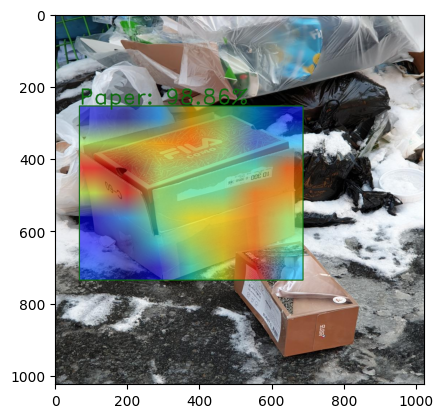

In [186]:
plt.imshow(visual)

In [417]:
from pycocotools.coco import COCO
data_path = '../../dataset/k-fold/val_fold_5.json'
coco = COCO(data_path)
image_infos = coco.loadImgs(coco.getImgIds())
coco.getImgIds()
img_pathes=[]
for i in coco.getImgIds():
    img_pathes.append(f"../../dataset/train/{i:04d}.jpg")

img_pathes = enumerate(img_pathes)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


4 Glass (176, 239, 443, 968) 0.40144715
5 Plastic (145, 218, 459, 971) 0.8448943
5 Plastic (406, 290, 683, 1008) 0.6199524
5 Plastic (411, 303, 650, 602) 0.5398837
9 Clothing (413, 264, 668, 1000) 0.69389737
9 Clothing (157, 191, 470, 988) 0.5659884


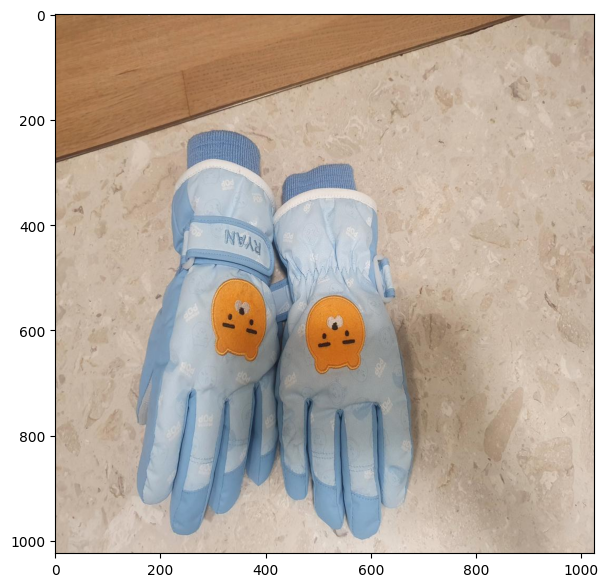

[4, 5, 5, 5, 9, 9]


In [420]:
img_path = next(img_pathes)[1]
image = cv2.imread(img_path)
out = inference_detector(model, image)
res = image.copy()
max_index=[]
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.4:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        max_index.append(i)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 1)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()
print(max_index)

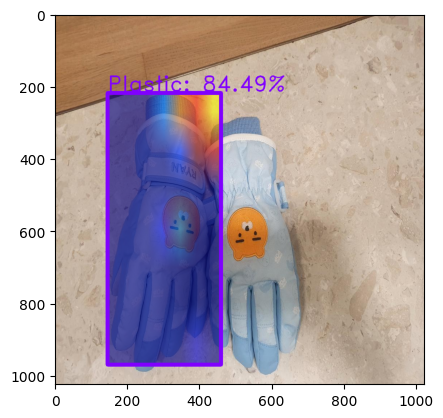

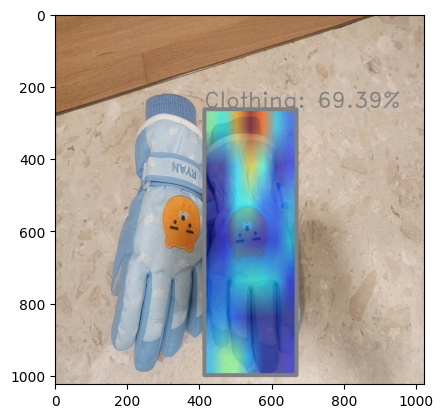

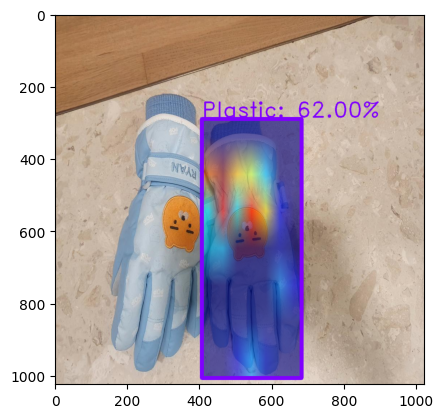

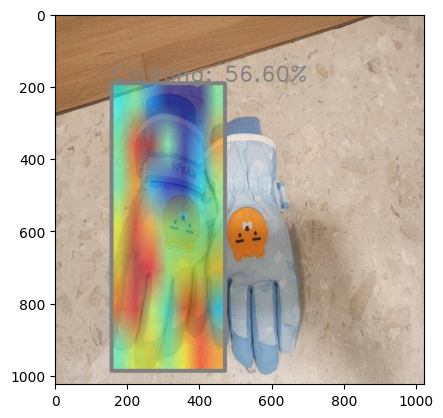

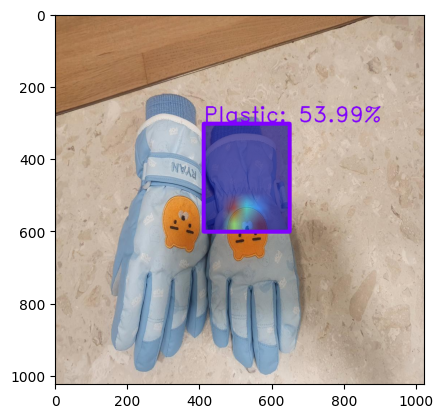

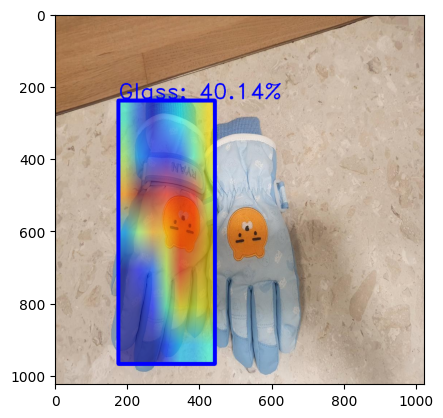

In [421]:
grad_cam = GradCAM_FRCN(model, 'roi_head.bbox_roi_extractor')
image = cv2.imread(img_path)
data = prepare_img(image)

## First is the data, second is the index of the predicted bbox
for idx, bbox_index in enumerate(max_index):
    mask, box, class_id, score = grad_cam(data, idx)

    COLORS = [[255,0,0],            # 빨강색 일쓰
              [255,127.5,0],        # 주황색 종이
              [255,255,0],          # 노랑색 종이팩
              [0,255,0],            # 초록색 금속
              [0,0,255],            # 파랑색 유리
              [127.5,0,255],        # 보라색 플라스틱
              [255,0,255],          # 마젠타 스티로폼
              [0,255,255],          # 하늘색 비닐봉투
              [255,127.5,127.5],    # 살색   빳데리
              [127.5,127.5,127.5]]  # 회색   의류
    visual = plot_cam_image(image[:, :, ::-1], mask, box, class_id, score, bbox_index, COLORS, label_names)
    plt.imshow(visual)
    plt.show()

In [234]:
print(max_index)

[1, 1, 5, 9]
